# Naive Classifier for Fake news recognition

## Packages

In [1]:
library(tidyverse)
library(ggplot2)
library(stopwords)
library(tidytext)
library(stringr)
library(purrr)
library(magrittr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




# Reading the data

In [2]:
train.filename <- 'dataset/archive/train.csv'
test.filename <- 'dataset/archive/test.csv'

In [3]:
train.df <- read.delim(train.filename, sep = ',')
test.df <- read.delim(test.filename, sep = ',')

### Second dataset

In [4]:
train2.filename <- 'dataset/fake-news/train.csv'
test2.filename <- 'dataset/fake-news/test.csv'

In [5]:
# train2.df <- read.delim(train2.filename, sep = ',')
# test2.df <- read.delim(test2.filename, sep = ',')

# Display the train and test datasets

In [6]:
# head(test.df)

In [7]:
# head(train.df)

In [8]:
# head(train2.df)

In [9]:
# head(test2.df)

# Splitting the datasets

In [10]:
# shuffle
set.seed(29062023)
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [11]:
# set splitting percentages
perc_split <- 0.8  # set splitting percentages
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

In [12]:
# splitting
train.df.train <- train.df[1:n_rows_train, ]
train.df.validation <- train.df[-c(1:n_rows_train), ]

In [13]:
cat('Total rows:',nrow(train.df),
    '\nTrain rows:',nrow(train.df.train),
    '\nValidation rows',nrow(train.df.validation))

Total rows: 10240 
Train rows: 8192 
Validation rows 2048

## Analysis of the content

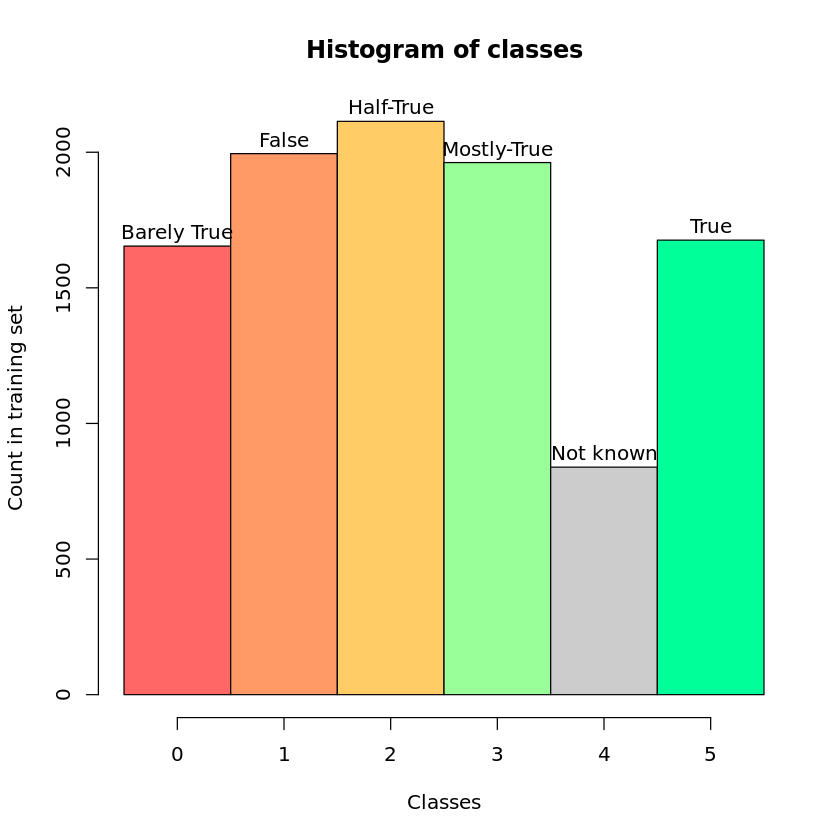

In [14]:
breaks <- seq(from=-0.5, to=5.5, by=1)
labels <- c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True')
colors <- c('#FF6666','#FF9966', '#FFCC66', '#99FF99' , '#CCCCCC','#00FF99')

class<-hist(x = train.df$Labels, 
     breaks = breaks, 
     labels = labels,
     main = 'Histogram of classes',
     xlab = 'Classes',
     ylab = 'Count in training set',
     col = colors
    )

## Defining the prior of each classes

In [15]:
prior.classes<-class$density

## Stop words

In [16]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Cleaning function

In [17]:
cleaning_tokens <- function(token.df){
    word <- ifelse(endsWith(token.df[,1], "s"), substr(token.df[,1], 1, nchar(token.df[,1]) - 1), token.df[,1])
    word <- ifelse(endsWith(word, "'"), substr(word, 1, nchar(word) - 1), word)
    word <- ifelse(str_detect(word, "[0-9]+"), '--number--', word)
#     word %<>% unique
    return(as.data.frame(word))
}

# Vocabulary

In [18]:
tags_numbers <- list(tags = c('Barely True', 'False', 'Half-True', 'Mostly-True', 'Not known', 'True'),
                     numbers = c(0:5))

In [19]:
## Vocabulary before feature selection

In [20]:
myframes <- list()

for (i in 1:length(tags_numbers$tags)) {
    tag <- tags_numbers$tags[i]

    train.df.train %>%
        filter(Labels == tags_numbers$numbers[i]) %>%
        select(Text) %>%
        unnest_tokens(word, Text) %>%
        anti_join(get_stopwords(), by = join_by(word)) %>%
        cleaning_tokens %>%
        arrange(word) %>%
        group_by(word) %>%
        reframe(counts = n()) %>%
        arrange(desc(counts)) %>%
        setNames(c("word", tag)) -> myframes[[i]]
}

In [21]:
counts<-purrr::reduce(myframes, dplyr::full_join, by = 'word')

In [22]:
head(counts)

word,Barely True,False,Half-True,Mostly-True,Not known,True
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
--number--,693,784,1106,1157,259,872
say,361,417,411,334,192,268
state,157,214,224,237,60,228
year,154,170,217,224,45,178
obama,134,164,142,84,105,73
percent,121,129,216,243,34,191


In [23]:
counts %<>% replace(is.na(.),0)

## Feature Selection 

## With frequency mean

In [24]:
counts %>%
    select(-word) %>%
    colSums() -> tot_counts_per_class

In [25]:
counts_prob <- cbind(counts["word"], counts[2:7]/tot_counts_per_class)

In [26]:
counts_prob["mean"] <- rowMeans(counts_prob[2:7])

In [27]:
counts_prob %>%
    arrange(desc(mean)) %>%
    top_frac(1, mean) -> vocabulary.train.features

In [28]:
head(vocabulary.train.features)

,word,Barely True,False,Half-True,Mostly-True,Not known,True,mean
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,--number--,0.045383104,0.043625842,0.072429601,0.064381504,0.016961362,0.04852262,0.048550672
2,say,0.020790141,0.056146493,0.023669661,0.044971052,0.011057360,0.03608456,0.032119877
3,obama,0.018042278,0.009444828,0.019119429,0.004837595,0.014137606,0.00420410,0.011630973
4,state,0.007935305,0.014492754,0.011321708,0.016050386,0.003032600,0.01544088,0.011378938
5,year,0.008569362,0.011132940,0.012075010,0.014669286,0.002504034,0.01165684,0.010101246
6,tax,0.005471090,0.014676181,0.006450127,0.014541538,0.002361207,0.01050222,0.009000394


In [29]:
counts %>%
    right_join(vocabulary.train.features["word"], by = join_by(word)) -> naive.bayes.vocabulary

In [30]:
length(naive.bayes.vocabulary[[1]])

[1] 9075

In [31]:
den <- tot_counts_per_class + length(naive.bayes.vocabulary[[1]])

In [32]:
den

Barely True       False   Half-True Mostly-True   Not known        True 
      24345       26439       28860       27046       16502       23841

In [33]:
likelihood.token <- cbind(naive.bayes.vocabulary["word"], (naive.bayes.vocabulary[2:7] + 1)/den)

## Nayve Bayes

In [34]:
# is.na(log(as.numeric(likelihood.token[likelihood.token['word']=='ciao'][2:6])))

# is.na(likelihood.token[likelihood.token['word']=='ciao'])

In [35]:
msg<-c('obama', 'percent', 'tommasomarco')

In [36]:
bayes.probability <- function(token.list, likelihood.token, prior.classes){
    query_out <- log(as.numeric(prior.classes))
    for (i in 1:length(token.list)) {
        query <- log(as.numeric(likelihood.token[likelihood.token["word"] == token.list[i]][2:7]))
        if (is.na(query[1])) {
        query <- as.numeric(log(1/den))
        }
    #### query is log likelihood for each class
        query_out <- query_out + query
    
    }
    query_out <- exp(query_out)
    query_out <- query_out/sum(query_out)
    return(query_out)
}

In [37]:
naive.bayes(msg, likelihood.token, prior.classes)

ERROR: Error in naive.bayes(msg, likelihood.token, prior.classes): could not find function "naive.bayes"


In [ ]:
tweet_tokenize <- function(msg){
    tib <- data.frame(msg)
    colnames(tib) <- 'tweet'
    tib %>% unnest_tokens(word, tweet) %>%
    anti_join(get_stopwords(), by = join_by(word)) %>%
    cleaning_tokens -> token.list
    return(token.list)    
}

In [ ]:
naive.bayes <- function(msg, likelihood.token, prior.classes){
    token.list<-as.vector(tweet_tokenize(msg))
    probability <- bayes.probability(token.list,likelihood.token, prior.classes )
    predicted_class <- which.max(probability)-1
    return(predicted_class)
}

## Test on validation set

In [ ]:
naive.bayes('Mister Obama joins nato', likelihood.token, prior.classes)

In [ ]:
predicted_classes <- lapply(X=train.df.validation$Text[1:20], FUN=naive.bayes,likelihood.token=likelihood.token,prior.classes=prior.classes)

In [ ]:
tweet_tokenize('Ciao tommaso come va?')

In [ ]:
sum(predicted_classes==train.df.validation$Labels[1:20])

In [ ]:
predicted_classes

In [ ]:
train.df.validation$Labels[1:20]

In [ ]:
train.df.validation

In [ ]:
tib <- tibble('Ciao tommaso come va?')
colnames(tib) <- 'tweet'

In [ ]:
tib %>% unnest_tokens(word, tweet)

## With absolute counts per class
To implement

In [ ]:
# train.df.train %>%
#     filter(Labels == 5) %>%
#     select(Text) %>%
#     unnest_tokens(word, Text) %>%
#     anti_join(get_stopwords(), by = join_by(word)) %>%
#     arrange(word) %>%
#     group_by(word) %>%
#     reframe(counts=n()) %>%
#     arrange(desc(counts)) -> true

## Naive Bayes Classifier

#### Some suggestion to create equivalence classes

In [ ]:
vocabulary.train %>%
    filter(grepl("al", word)) %>%
    head

In [ ]:
vocabulary.train.cleaned %>%
    filter(grepl("\\'s", word))

In [ ]:
train.df %>%
    filter(grepl("06", Text)) %>%
    filter(!grepl("2006", Text))  #%>% summarise(n())

## About the data

# Count how many topics there are

In [38]:
train.df.train %>%
    select(Text_Tag) %>%
    unnest_tokens(word, Text_Tag, token = stringr::str_split, pattern = ",") %>%
    unique %>%
    arrange(word) -> topics

In [39]:
train.df.train  %>% filter(Text_Tag=='')

Labels,Text,Text_Tag
<int>,<chr>,<chr>
1,"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.'' abortion barack-obama President Illinois democrat 70 71 160 163 9 a TV interview with megachurch pastor Rick Warren in Lake Forest, Calif. 2724.json true Most of the jobs that we lost were lost before the economic policies we put in place had any effect. economy,job-accomplishments,jobs,stimulus barack-obama President Illinois democrat 70 71 160 163 9 an interview on The Daily Show with Jon Stewart""",
1,"Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.'' health-care,taxes richard-durbin Senator Illinois democrat 0 2 1 0 1 a comment on the Morning Joe'' show on MSNBC.",


In [40]:
topics<-as.list(topics)$word

#### Number of unique topics

In [41]:
length(topics)

[1] 141

#### Most frequent and infrequent topics

In [42]:
counts<-vector()
for(i in seq_along(topics)){
    counts[i]<- as.numeric(train.df.train %>% filter(grepl(topics[i], Text_Tag)) %>% summarise(n()))
    }

In [43]:
topics_counts <- data.frame(topics, counts)

In [56]:
topics_counts %>%
    filter(topics != "") %>%
    arrange(desc(counts)) 

topics,counts
<chr>,<dbl>
economy,927
health-care,908
taxes,787
federal-budget,583
jobs,580
education,575
state-budget,562
candidates-biography,512
elections,480


In [45]:
topics_counts %>%
    arrange(counts) %>%
    head()

,topics,counts
,<chr>,<dbl>
1,alcohol,0
2,death-penalty,1
3,after-the-fact,2
4,autism,3
5,colbert-report,3
6,fake-news,3


In [73]:
train.df.train %>%
    filter(grepl("economy", Text_Tag))%>%
    filter(!grepl("health-care", Text_Tag)) %>%
    filter(!grepl("taxes", Text_Tag))%>% mutate(Labels=0) -> economy

train.df.train %>%
    filter(!grepl("economy", Text_Tag))%>%
    filter(grepl("health-care", Text_Tag)) %>%
    filter(!grepl("taxes", Text_Tag))%>% mutate(Labels=1) -> health_care

train.df.train %>%
    filter(!grepl("economy", Text_Tag))%>%
    filter(!grepl("health-care", Text_Tag)) %>%
    filter(grepl("taxes", Text_Tag)) %>% mutate(Labels=2) -> taxes

train<- rbind(economy, health_care, taxes)

In [77]:
train

Labels,Text,Text_Tag
<dbl>,<chr>,<chr>
0,Youth unemployment is through the roof.,economy
0,"In 2006, I went out and authored a letter with 24 other senators asking for major reform of Freddie and Fannie, warning of a meltdown and a bubble in the housing market.","candidates-biography,economy,financial-regulation,housing"
0,"John McCain has said the economy is ""not his strong suit.""",economy
0,"Dont believe those phony numbers when you hear 4.9 and 5 percent unemployment. The numbers probably 28, 29, as high as 35. In fact, I even heard recently 42 percent.","economy,jobs"
0,My opponent promises to bring back old jobs by wishing away the global economy.,economy
0,"For four years, we balanced the budget and paid off $405 billion in debt.","deficit,economy,federal-budget"
0,"There is a provision in the economic stimulus plan that means that ""students cannot meet together in their dorms, if that dorm has been repaired with this federal money, and have a prayer group or a Bible study.""","economy,education,stimulus"
0,"As Houstons mayor, I helped our area lead the nation in job growth.","economy,job-accomplishments"
0,"In the 18th Congressional District, 100% of electric generation comes from coal.","cap-and-trade,climate-change,economy,energy"
